# Antibody Classifier Analysis

## Introduction

This report will present final analysis on processed antibody data acquired from [OAS](https://opig.stats.ox.ac.uk/webapps/oas/dataunit?unit=Briney_2019/csv/SRR8283601_1_Heavy_Bulk.csv.gz) and the [Therapeutic Structural Antibody Database](https://opig.stats.ox.ac.uk/webapps/sabdab-sabpred/therasabdab/search/). The purpose of this project is to take raw antibody sequences and build an automated pipeline using Snakemake that builds and processes them with a protein language model to generate embeddings which will be used to train a stacked ensemble model classifier to predict the binding potential of a given antibody sequence.

### Biological Background and ML approach

When considering the results of this notebook there are two key biological considerations regarding how the data was chosen the reader must be aware of. First, Bulk antibody data pulled from OAS serves as a proxy for non-binding antibodies and the TheraSAbDab data serves as a proxy for binding antibodies. While this is acceptable for a machine learning project, it should be noted that a more robust approach suitable for therapeutic applications requires experimentally verified binding data. Second, in order to make the data manageable, only sequence data for the [variable heavy domain](https://www.ncbi.nlm.nih.gov/books/NBK27144) of a given antibody was used. [This is because the *majority* of binding variation in antibodies is determined by the variable heavy domain](https://pmc.ncbi.nlm.nih.gov/articles/PMC4941225).

The dataset for the non-binding proxy was pulled from a nature publication by [Briney et. al.](https://www.nature.com/articles/s41586-019-0879-y) the original study was focused on highlighting baseline commonalities in human antibodies despite the number of unique antibodies present approaching one trillion. Because the objective of the study was to analyse a wide range of antibody types, the data was determined to well suited to serve as a stand in for non-therapeutic binding antibodies.

The dataset serving as a proxy for binding sites with therapeutic value is from TheraSAbDab. It is carefully curated to contain only antibodies with binding sites known to have therapeutic use and provides the corresponding variable domain sequence.

data from both of these datasets were randomized and combined such that a 50/50 split of non-binding, and binding classes was obtained. The sequences in this data set was then fed into the 650 million parameter [esm2](https://github.com/facebookresearch/esm) model and mean-pooled sequence embeddings generated. It should be noted that an antibody specific model may produce better results than the broad protein language model chosen here given unique properties of antibodies.

This new dataset with embeddings will be used to train a stacked ensemble classifier from Random Forest, Xgboost, and SVM base learners. It should be noted that other properties such as melting point, colloidal stability, solubility, etc. would likely enhance the accuracy of the model but will not be included here.

## EDA

A brief exploration of the data performed here will confirm the previous processing steps were correctly performed. This includes checking for class imbalance, and confirming the size of the dataset.

In [15]:
# load packages and data

import pandas as pd
import matplotlib.pyplot as plt

from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split, RandomizedSearchCV 
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import StackingClassifier
from sklearn.linear_model import LogisticRegression

df = pd.read_csv("../data/embeds_df.csv")

In [16]:
df.head()

,sequence_id,sequence,class,em_000,em_001,em_002,em_003,em_004,em_005,em_006,...,em_1270,em_1271,em_1272,em_1273,em_1274,em_1275,em_1276,em_1277,em_1278,em_1279
0,oas_9883,GACTGGGGGGTGCCTGAGTCTCTCCTGTGCAGCCTCTCGATTGACC...,0,-0.181649,-0.090733,0.036329,0.100591,0.095663,0.268051,0.090245,...,-0.081227,-0.208845,0.093939,-0.075376,0.015705,-0.226980,-0.140334,0.085658,0.036633,-0.091008
1,thera_455,EVQLVQSGAEVKKPGESLKISCKGSGYSFTSYWIGWVRQMPGKGLE...,1,-0.064848,-0.042365,-0.118699,0.221329,-0.188070,-0.069189,0.165545,...,-0.079416,-0.063370,-0.130252,-0.024889,-0.026694,-0.039239,0.147878,-0.154017,-0.017085,0.055484
2,oas_8500,TGCTGGGGGGTCCCTGAGCCTCTCCTGTGCAGCCTCTGGATTCACC...,0,-0.194062,-0.072394,0.043490,0.090048,0.090608,0.277665,0.095308,...,-0.094786,-0.198245,0.085272,-0.049258,0.015839,-0.199463,-0.115709,0.093589,-0.002647,-0.078949
3,oas_2232,CGCTGGGGGGTCCCTGAGACTCTCCTGTGCAGCCTCTGGATTCACC...,0,-0.175457,-0.078911,0.041559,0.102644,0.079346,0.225728,0.081930,...,-0.089858,-0.199157,0.084745,-0.035571,0.030047,-0.253706,-0.094550,0.077255,0.023875,-0.077019
4,oas_13474,TTTGCGGGGAGTCTCTGAAGATCTCCTGTAAGGCTTCTGGATATAA...,0,-0.170610,-0.102347,0.032305,0.112327,0.077862,0.179571,0.056705,...,-0.062803,-0.189503,0.080321,-0.022664,0.044877,-0.258741,-0.107571,0.060990,0.009830,-0.075434


The data correctly displays a 5x1283 matrix with 1280 columns representing the embeddings from the esm model, the associated sequence, id for the sequence, and its class. Now class imbalance must be assessed.

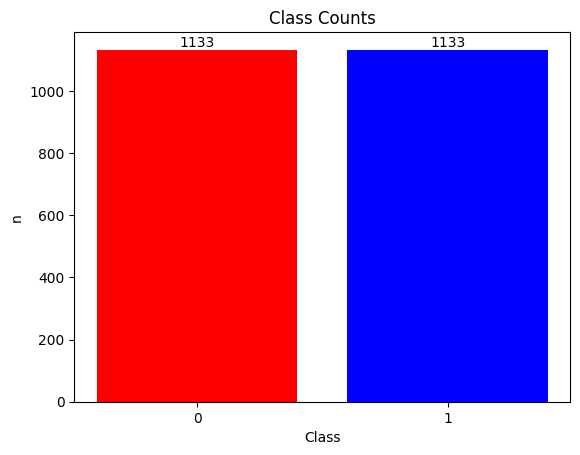

In [17]:
class_counts = df['class'].value_counts()

bar_plot = plt.bar(class_counts.index,class_counts.values, color=['r','b'])
plt.title('Class Counts')
plt.xlabel('Class')
plt.ylabel('n')
plt.xticks([0,1])
plt.bar_label(bar_plot, labels=class_counts.values)
plt.show()

The plot above shows that the dataset is balanced with 1133 observations of each class.

## Base Model Construction and Evaluation

Three models will be built using k-fold validation and key statistics such as AUC-ROC and F1 score compared.